## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning can get with only 10% of the training data, but how does it go with 1% of training data?

1. 'model_1' - use feature extraction transfer learning with 1% of training data with data augmentation
2. 'model_2' - use feature extraction transfer learning with 10% of training data with data augmentation
3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. 'model_4' - use fine-tuning transfer learning on 100% of training data with data augmentation

**Same dataset will be used**


In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [2]:
# Download data (preprocessed from food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-07-11 11:18:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:820::201b, 2404:6800:4009:824::201b, 2404:6800:4009:825::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:820::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: '10_food_classes_1_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  123K 17m43s
    50K .......... .......... .......... .......... ..........  0%  174K 15m5s
   100K .......... .......... .......... .......... ..........  0%  450K 11m40s
   150K .......... .......... .......... .......... ..........  0%  464K 9m55s
   200K .......... .......... .......... .......... ..........  0%  547K 8m43s
   250K .......... .......... .......... .......... ..........  0%  711K 7m46s
   300K .......... ..........

In [3]:
train_dir_1_percent = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_1_percent/train"
test_dir_1_percent = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_1_percent/test"

In [4]:
# How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [5]:
import tensorflow as tf

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
     

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

augmented_img = data_augmentation(img, training=True)

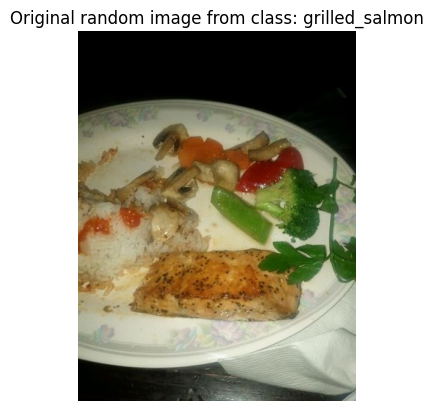

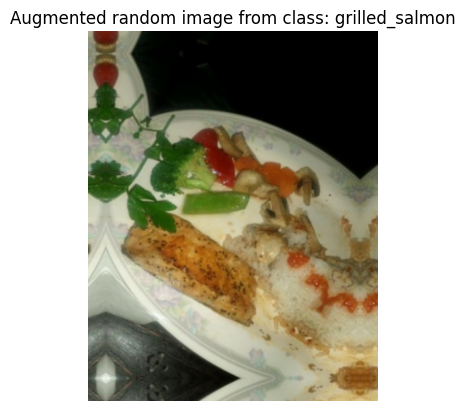

In [8]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

# Setup input shape and base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, input_shape=input_shape)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir_1_percent = '10_food_classes_1_percent/test'

# Load the datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Function to convert integer labels to one-hot encoded labels
def one_hot_encode(dataset, num_classes=10):
    def encode(image, label):
        label = tf.one_hot(label, num_classes)
        return image, label
    return dataset.map(encode)

# One-hot encode the datasets
train_dataset = one_hot_encode(train_dataset)
validation_dataset = one_hot_encode(validation_dataset)

# Placeholder for creating a tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensorboard_callback

history_1_percent = model_1.fit(train_dataset,
                                epochs=10,
                                validation_data=validation_dataset,
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Found 70 files belonging to 10 classes.
Using 56 files for training.
Found 2500 files belonging to 10 classes.
Using 500 files for validation.
Epoch 1/10
2/2 [==============================] - 35s 9s/step - loss: 2.4074 - accuracy: 0.0893 - val_loss: 2.2577 - val_accuracy: 0.1600
Epoch 2/10
2/2 [==============================] - 4s 3s/step - loss: 2.2407 - accuracy: 0.1607 - val_loss: 2.1752 - val_accuracy: 0.2220
Epoch 3/10
2/2 [==============================] - 4s 3s/step - loss: 2.0623 - accuracy: 0.2857 - val_loss: 2.0971 - val_accuracy: 0.2840
Epoch 4/10
2/2 [==============================] - 4s 3s/step - loss: 1.9071 - accuracy: 0.4464 - val_loss: 2.0247 - val_accuracy: 0.3320
Epoch 5/10
2/2 [==============================] - 4s 3s/step - loss: 1.7796 - accuracy: 0.5179 - val_loss: 1.9550 - val_accuracy: 0.3980
Epoch 6/10
2/2 [==============================] - 4s 3s/step - loss: 1.7255 - accuracy: 0.6071 - val_loss: 1.8886 - val_accuracy: 0.4280
Epoch 7/10
2/2 [==================

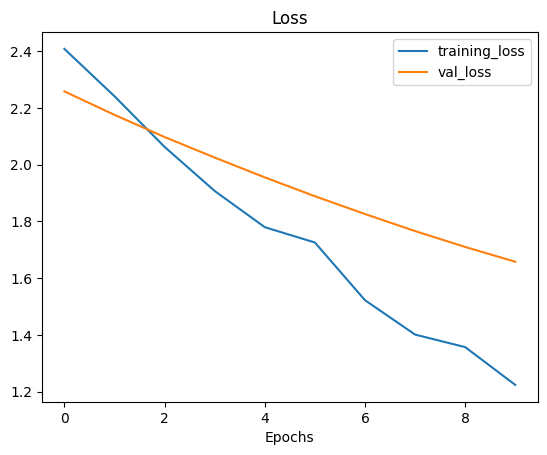

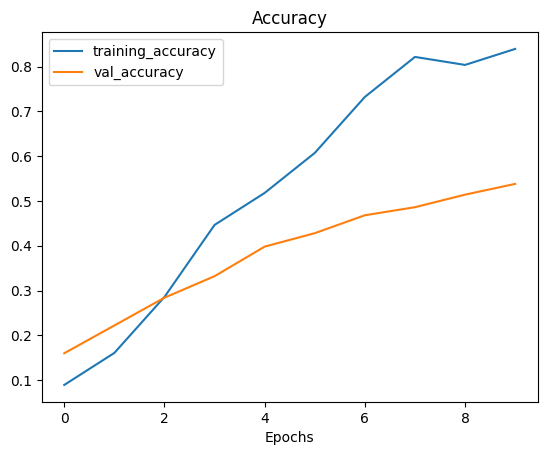

In [10]:
plot_loss_curves(history_1_percent)

In [11]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

In [12]:
# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# One-hot encode the labels
test_dataset = one_hot_encode(test_dataset)

# Evaluate the model
results = model_1.evaluate(test_dataset)

# Print the results
print(f"Test loss: {results[0]:.4f}")
print(f"Test accuracy: {results[1]:.4f}")

Found 2500 files belonging to 10 classes.
79/79 [==============================] - 12s 139ms/step - loss: 1.6551 - accuracy: 0.5312
Test loss: 1.6551
Test accuracy: 0.5312
